<a href="https://colab.research.google.com/github/JN513/mask_detect/blob/master/notebooks/mask_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detector de pessoas com  mascaras, com python e tensorflow

datasets: 

https://github.com/JN513/mask_detect

https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset

baseado em: https://github.com/gorpo/Face-Recognition-Detector-de-Mascara-Python-Covid-19/

Repositorio do projeto: https://github.com/JN513/mask_detect

Clonado repositorio e movendo detectores de face

In [4]:
!git clone https://github.com/JN513/mask_detect.git
!mkdir /content/classificadores/
!cp /content/mask_detect/classificadores/deploy.prototxt /content/classificadores/deploy.txt 
!cp /content/mask_detect/classificadores/res10_300x300_ssd_iter_140000.caffemodel /content/classificadores/res10_300x300_ssd_iter_140000.caffemodel


Importando dataset do kaggle e upando a key

Movendo as imagens, para as pastas, essa parte (Essa paret = 2 proximas celulas) e opcional e exige uma key do kaggle

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user YOUR_USER — sort-by 
!kaggle datasets download -d prasoonkottarathil/face-mask-lite-dataset

!unzip /content/face-mask-lite-dataset.zip

TypeError: ignored

In [5]:
!mv  /content/with_mask/* /content/mask_detect/dataset/com_mascara
!mv  /content/without_mask/* /content/mask_detect/dataset/sem_mascara

mv: cannot stat '/content/with_mask/*': No such file or directory
mv: cannot stat '/content/without_mask/*': No such file or directory


Importando as bibliotecas e pacotes necessarios

In [18]:
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os
from sklearn.metrics import accuracy_score, confusion_matrix

Carregando as imagens e processando as labels

In [7]:
print('[INFO] Carregando imagens ...')
#carregando imagens
caminho_imagens = list(paths.list_images('/content/mask_detect/dataset'))

print(f"Total de imagens: {len(caminho_imagens)}")

imagens = []
labels = []
#pegando o label e a imagem e add em listas
for path in caminho_imagens:
    label = path.split(os.path.sep)[-2]
    #abrindo e processando as imagens
    imagem = load_img(path, target_size=(224, 224))
    imagem = img_to_array(imagem)
    imagem = preprocess_input(imagem)

    imagens.append(imagem)
    labels.append(label)

#transformando em array numpy
imagens = np.array(imagens, dtype='float32')
labels = np.array(labels)
print('[INFO] Carregando imagens ...')

[INFO] Carregando imagens ...
Total de imagens: 1164
[INFO] Carregando imagens ...


Executando codificação one-hot nas etiquetas/labels

In [8]:
# executar codificação one-hot nas etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Partindo os dados em treinamento e teste

In [9]:
# particione os dados em divisões de treinamento e teste usando 75% dos dados para treinamento e os 25% restantes para teste
print('[INFO] particionando imagens e labels ...')
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=42)

[INFO] particionando imagens e labels ...


Construindo gerador de iamgens, gerando e compilando modelo

In [10]:
# construindo o gerador de imagens de treinamento para aumento de dados
gerador = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# carregando a rede MobileNetV2, garantindo que os conjuntos de camadas FC principais sejam deixados de lado
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))

# construindo a cabeça do modelo que será colocado em cima do modelo base
print('[INFO] gerando modelo ...')

modelo_cabeca = baseModel.output
modelo_cabeca = keras.layers.AveragePooling2D(pool_size=(7, 7))(modelo_cabeca)
modelo_cabeca = keras.layers.Flatten(name="flatten")(modelo_cabeca)
modelo_cabeca = keras.layers.Dense(128, activation="relu")(modelo_cabeca)
modelo_cabeca = keras.layers.Dropout(0.5)(modelo_cabeca)
modelo_cabeca = keras.layers.Dense(2, activation="softmax")(modelo_cabeca)

#criando o modelo principal sobre o base
modelo = Model(inputs=baseModel.input, outputs=modelo_cabeca)

# percorre todas as camadas no modelo base e as congela para que elas * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
	  layer.trainable = False

#compilando o modelo
print('[INFO] compilando modelo ...')

modelo.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

print('[INFO] modelo finalizado ...')

9412608/9406464 [==============================] - 0s 0us/step
[INFO] gerando modelo ...
[INFO] compilando modelo ...
[INFO] modelo finalizado ...


Compilando modelo

In [11]:
# inicialize a taxa de aprendizado inicial, número de épocas para treinamento e tamanho do lote
inicia_apredizado = 1e-4
quantidade_treinos = 110
tamanho_lote = 32

# treinar a cabeça
print("[INFO] treinando modelo ...")
cabeca = modelo.fit(gerador.flow(trainX, trainY, batch_size=tamanho_lote), steps_per_epoch=len(trainX) // tamanho_lote, validation_data=(testX, testY), validation_steps=len(testX) // tamanho_lote, epochs=quantidade_treinos)
print('[INFO] modelo treinado com sucesso ...')

[INFO] treinando modelo ...
Epoch 1/110
29/29 [==============================] - 46s 1s/step - loss: 0.3730 - accuracy: 0.8503 - val_loss: 0.0122 - val_accuracy: 0.9957
Epoch 2/110
29/29 [==============================] - 42s 1s/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 3/110
29/29 [==============================] - 42s 1s/step - loss: 0.0362 - accuracy: 0.9907 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 4/110
29/29 [==============================] - 42s 1s/step - loss: 0.0245 - accuracy: 0.9927 - val_loss: 0.0154 - val_accuracy: 0.9914
Epoch 5/110
29/29 [==============================] - 42s 1s/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 6/110
29/29 [==============================] - 42s 1s/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0049 - val_accuracy: 0.9957
Epoch 7/110
29/29 [==============================] - 42s 1s/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.0044 - val_ac

Avaliando a rede neural

In [25]:
# fazendo predições na rede neural
print("[INFO] avaliando a rede neural...")
predIdxs = modelo.predict(testX, batch_size=tamanho_lote)

# para cada imagem no conjunto de testes, precisamos encontrar o índice do rótulo com a maior probabilidade prevista correspondente
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,	target_names=lb.classes_))


accuracy = accuracy_score(testY.argmax(axis=1), predIdxs)

acertos_de_cada = confusion_matrix(testY.argmax(axis=1), predIdxs)

# Classe 1 Classe 2
# True False acertou x classe 1 e errou y classe 2
# False True errou x classe 1 acertou y classe 2

print(f"Acuracia: {accuracy}")
print(acertos_de_cada)

[INFO] avaliando a rede neural...
              precision    recall  f1-score   support

 com_mascara       1.00      1.00      1.00       113
 sem_mascara       1.00      1.00      1.00       120

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233

Acuracia: 1.0
[[113   0]
 [  0 120]]


Salvando modelo

In [34]:
# salvando o modelo
print("[INFO] salvando o modelo...")
modelo.save("/content/classificadores/mask_detector.model", save_format="h5")

[INFO] salvando o modelo...


Salvando modelo na "/"

In [40]:
# salvando o modelo
print("[INFO] salvando o modelo...")
modelo.save("mask_detector.model", save_format="h5")

[INFO] salvando o modelo...


Traçando a perda e a precisçao do treinamento

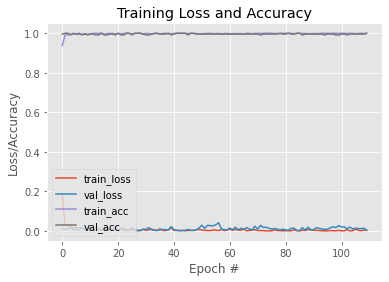

In [42]:
# traçar a perda e a precisão do trenamento
N = quantidade_treinos
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), cabeca.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), cabeca.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), cabeca.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), cabeca.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()

Traçando acuracia

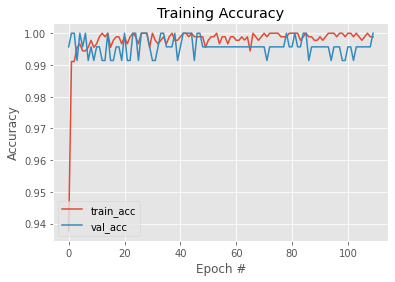

In [28]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), cabeca.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), cabeca.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotacc.png")
plt.show()

traçando loss


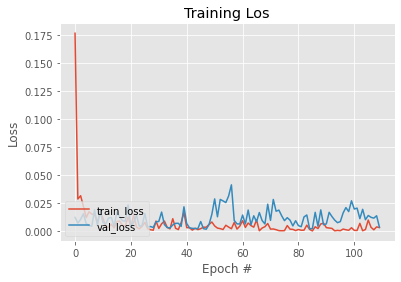

In [41]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), cabeca.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), cabeca.history["val_loss"], label="val_loss")
plt.title("Training Los")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plotloss.png")
plt.show()

Teste com uma imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


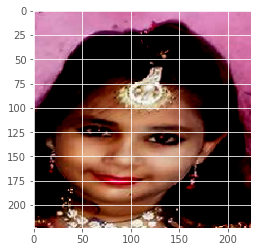

In [30]:
predIdxs = modelo.predict(testX)
predIdxs = np.argmax(predIdxs[0])
print(predIdxs)

plt.imshow(testX[0])
plt.show()

Teste com outra imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
0.98649305
0.013506927
0


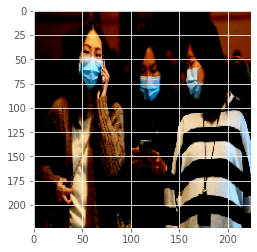

In [32]:
path="/content/mask_detect/testes/1.png"

imagem = load_img(path, target_size=(224, 224))
imagem = img_to_array(imagem)
imagem = preprocess_input(imagem)

imagem = np.array(imagem, dtype='float32')
print(imagem.shape)
imagens = [imagem]
imagens = np.array(imagens, dtype='float32')

(mask, withoutMask) = modelo.predict(imagens)[0]
print(mask)
print(withoutMask)
predIdxs = modelo.predict(imagens)
predIdxs = np.argmax(predIdxs)
print(predIdxs)

plt.imshow(imagem)
plt.show()

Mostrar pessoas com mascaras e pessoas sem mascaras em uma imagem

Carregando modelos

In [35]:
#mostrar mascara em uma imagem

# carrega modelo de detector de rosto serializado a partir do disco
print("[INFO] carregando modelo detector de faces...")
prototxtPath = os.path.sep.join(["/content/classificadores/deploy.txt"])
weightsPath = os.path.sep.join(	["/content/classificadores/res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# carregar o modelo do detector de máscara facial a partir do disco
print("[INFO] carregando modelo...")
modelo = load_model("/content/classificadores/mask_detector.model")

[INFO] carregando modelo detector de faces...
[INFO] carregando modelo...


Carregando a image,

In [36]:
#carrega a imagem
print("[INFO] carregando imagem...")
imagem = cv2.imread('/content/mask_detect/testes/1.png')
#copiando imagem
origem = imagem.copy()
(h, w) = imagem.shape[:2]

[INFO] carregando imagem...


Craindo blob e detectando faces na imagem

In [37]:
# construir um blob a partir da imagem
blob = cv2.dnn.blobFromImage(imagem, 1.0, (300, 300), (104.0, 177.0, 123.0))
# passe o blob pela rede e obtenha as detecções de rosto

print("[INFO] computando deteccoes faciais...")
net.setInput(blob)
deteccoes = net.forward()

[INFO] computando deteccoes faciais...


Detectando as pessoas com e sem mascara e desenhando retangulo em volta.

1.0 1.680103e-17
1.0 3.2704173e-11
1.0 4.914757e-13


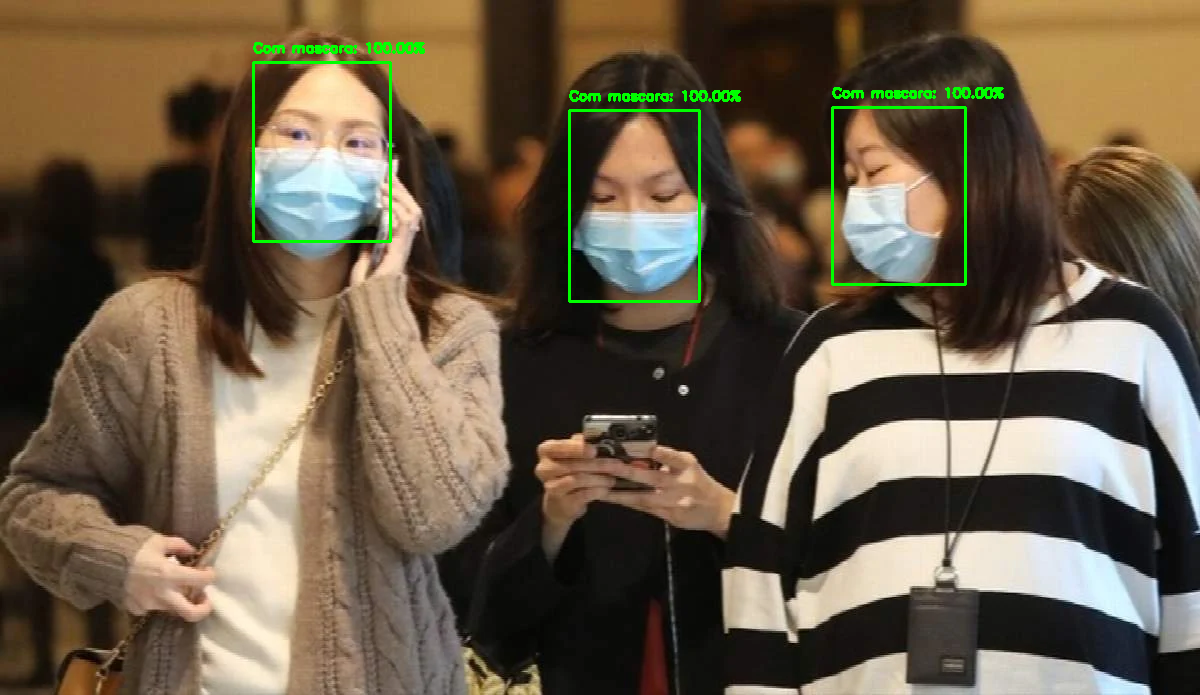

In [39]:
# loop sobre as detecçoes
for i in range(0, deteccoes.shape[2]):
	# extrair a confiança (ou seja, probabilidade) associada à detecção
    confianca = deteccoes[0, 0, i, 2]
    # filtrar detecções fracas, garantindo que a confiança seja maior que a confiança mínima
    if confianca > 0.5:
        # calcular as coordenadas (x, y) da caixa delimitadora para o objeto
        box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # verifique se as caixas delimitadoras estão dentro das dimensões do 
        
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))		
        
		# extrai o ROI da face, converte-o de pedido de canal BGR para RGB, redimensione-o para 224x224 e pré-processe
        face = imagem[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

		# passa a iamgem no modelo, para verificar a exixtencia de uma mascara ou não
        (mask, withoutMask) = modelo.predict(face)[0]

        #determinado a label e a cor do quadrado
        label = "Com mascara" if mask > withoutMask else "Sem mascara"
        color = (0, 255, 0) if label == "Com mascara" else (0, 0, 255)

		# inclui a probabilidade na label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# exibir a label e o retângulo da caixa delimitadora no quadro de saída

        cv2.putText(imagem, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(imagem, (startX, startY), (endX, endY), color, 2)

# Mostra a imagem final
cv2_imshow(imagem)